## Implement canny edge detection algorithm
## 20BCE057
# Devasy Patel

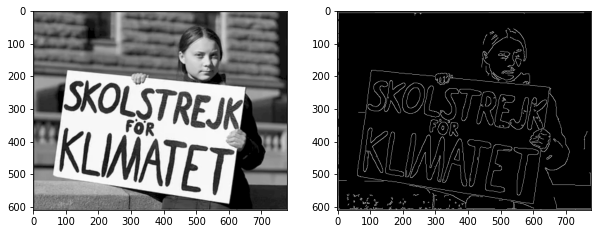

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('canny2.png', 0)
edges = cv2.Canny(img, 100, 200)

ax, fig = plt.subplots(1, 2, figsize=(10, 5))
fig[0].imshow(img, cmap='gray')
fig[1].imshow(edges, cmap='gray')
plt.show()


# step 1: Gaussian filter
# step 2: Gradient calculation
# step 3: Non-maximum suppression
# step 4: Double threshold
# step 5: Edge tracking by hysteresis

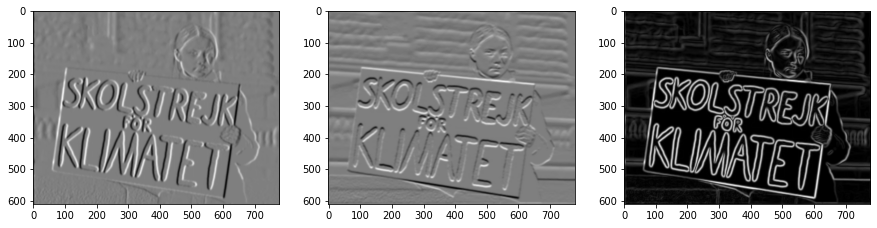

In [89]:
# implementing step 1
smoothed_img = cv2.GaussianBlur(img, (11, 11), 0)

# implementing step 2
sobelx = cv2.Sobel(smoothed_img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(smoothed_img, cv2.CV_64F, 0, 1, ksize=5)

# implementing step 3
mag = np.sqrt(sobelx**2 + sobely**2)
# mag = np.uint8(mag)

axes, fig = plt.subplots(1, 3, figsize=(15, 15))
fig[0].imshow(sobelx, cmap='gray')
fig[1].imshow(sobely, cmap='gray')
fig[2].imshow(mag, cmap='gray')



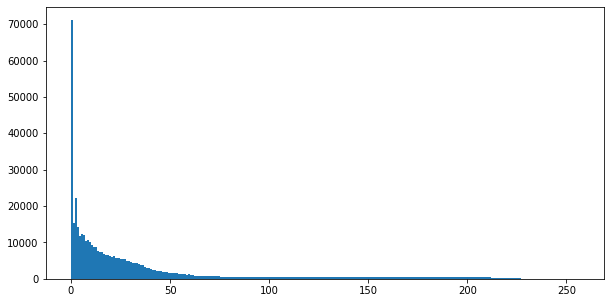

49.2658094682519


In [96]:
# plot histogram of magnitude
plt.figure(figsize=(10, 5))
plt.hist(mag.ravel(), 256, [0, 256])
plt.show()

# find a threshold value where 50% of the pixels are above the threshold
thresh = np.percentile(mag, 80)
t1 = np.percentile(mag, 50)
print(thresh)

255.0 0.0


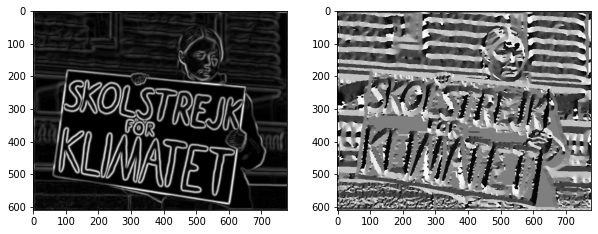

In [90]:
mag = mag / np.max(mag) * 255
theta = np.arctan2(sobely, sobelx)
ax, fig = plt.subplots(1, 2, figsize=(10, 5))
fig[0].imshow(mag, cmap='gray')
fig[1].imshow(theta, cmap='gray')

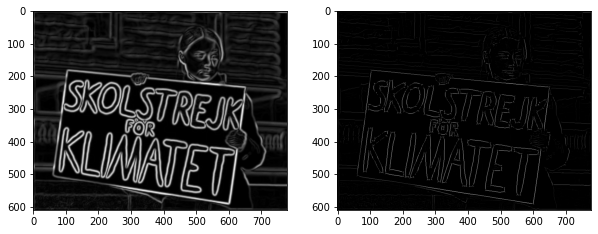

In [93]:
def NMS(G, theta):
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.int32) # resultant image
    angle = theta * 180. / np.pi        # max -> 180, min -> -180
    angle[angle < 0] += 180             # max -> 180, min -> 0

    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255
            
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                r = G[i, j-1]
                q = G[i, j+1]

            elif (22.5 <= angle[i,j] < 67.5):
                r = G[i-1, j+1]
                q = G[i+1, j-1]

            elif (67.5 <= angle[i,j] < 112.5):
                r = G[i-1, j]
                q = G[i+1, j]

            elif (112.5 <= angle[i,j] < 157.5):
                r = G[i+1, j+1]
                q = G[i-1, j-1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
            else:
                Z[i,j] = 0
    return Z

Z = NMS(mag, theta)
ax, fig = plt.subplots(1, 2, figsize=(10, 5))
fig[0].imshow(mag, cmap='gray')
fig[1].imshow(Z, cmap='gray')

49.2 15.5
25 255


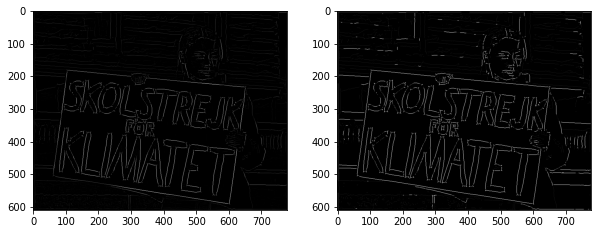

In [97]:
def Threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    # highThreshold = img.max() * highThresholdRatio
    highThreshold = 49.2
    lowThreshold = 15.5
    # lowThreshold = highThreshold * lowThresholdRatio
    print(highThreshold, lowThreshold)
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

res, weak, strong = Threshold(Z)
print(weak, strong)
ax, fig = plt.subplots(1, 2, figsize=(10, 5))
fig[0].imshow(Z, cmap='gray')
fig[1].imshow(res, cmap='gray')
# fig[2].imshow(weak, cmap='gray')
# fig[3].imshow(strong, cmap='gray')


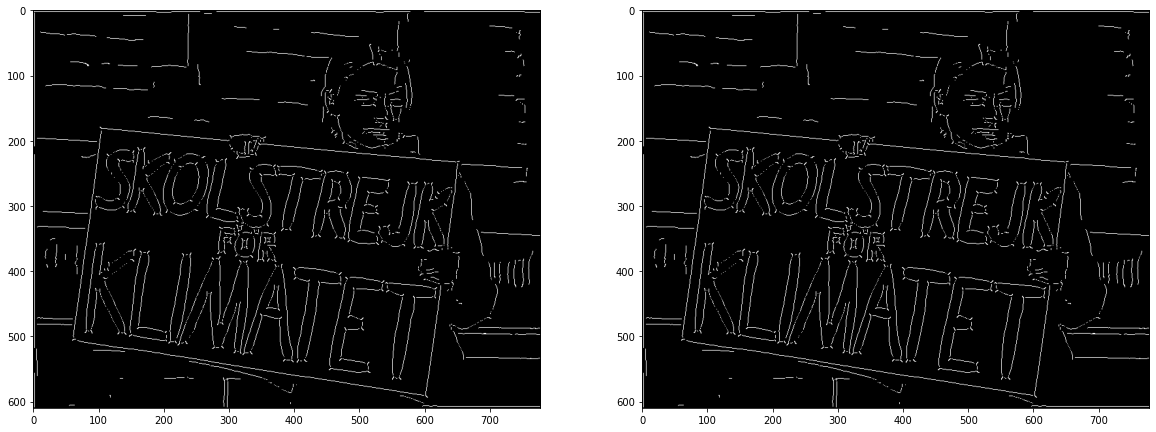

In [98]:

def hysteresis(img, weak, strong=255):
    M, N = img.shape

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                if (
                    (img[i+1, j-1] == strong) or (img[i+1, j] == strong) or
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)
                ):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

img_final = hysteresis(res,25, 255)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(res, cmap='gray')
ax[1].imshow(img_final, cmap='gray')

## Appendix section

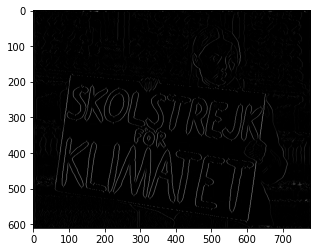

In [82]:
# non-maximum suppression

def non_max_suppression(mag, sobelx, sobely):
    height, width = mag.shape
    res = np.zeros((height, width))
    angle = (np.arctan2(sobely, sobelx))
    angle[angle < 0] += 180

    for i in range(1, height-1):
        for j in range(1, width-1):
            q = 255
            r = 255

            # angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = mag[i, j+1]
                r = mag[i, j-1]
            # angle 45
            elif (22.5 <= angle[i, j] < 67.5):
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            # angle 90
            elif (67.5 <= angle[i, j] < 112.5):
                q = mag[i+1, j]
                r = mag[i-1, j]
            # angle 135
            elif (112.5 <= angle[i, j] < 157.5):
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]

            if (mag[i, j] >= q) and (mag[i, j] >= r):
                res[i, j] = mag[i, j]
            else:
                res[i, j] = 0

    return res

 
nonmax_img = non_max_suppression(mag, sobelx, sobely)

plt.imshow(nonmax_img, cmap='gray')

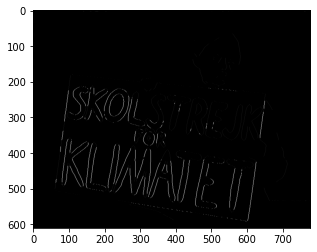

In [87]:
# applying double threshold
 
def double_threshold(img, low, high):
    height, width = img.shape
    res = np.zeros((height, width))

    weak = 25
    strong = 255

    strong_i, strong_j = np.where(img >= high)
    zeros_i, zeros_j = np.where(img < low)

    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res

 
double_threshold_img = double_threshold(nonmax_img, 100, 200)
plt.imshow(double_threshold_img, cmap='gray')

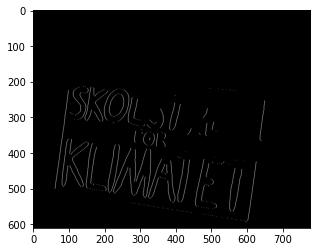

In [86]:
# applying hysteresis
 
def hysteresis(img, weak, strong=255):
    
    height, width = img.shape
    for i in range(1, height-1):
        for j in range(1, width-1):
            if img[i, j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0

    return img

 
hysteresis_img = hysteresis(double_threshold_img, 25, 255)
plt.imshow(hysteresis_img, cmap='gray')


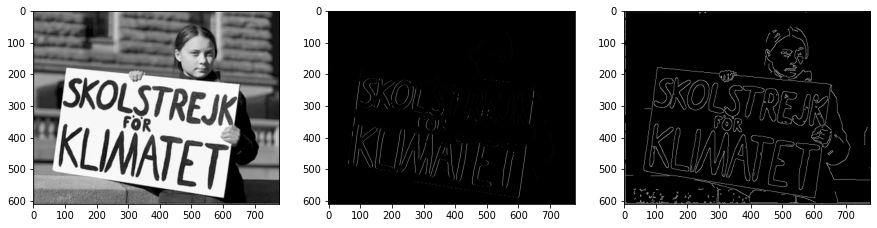

In [85]:
ax, fig = plt.subplots(1, 3, figsize=(15, 5))
fig[0].imshow(img, cmap='gray')
fig[1].imshow(hysteresis_img, cmap='gray')
fig[2].imshow(cv2.Canny(img, 100, 200), cmap='gray')
plt.show()
